In [ ]:
# results directories:
# /home/jxm3/random/interpretable-autoprompting/results/intermediate_results_from_chandan/anli
# /home/jxm3/random/interpretable-autoprompting/results/intermediate_results_from_chandan/math

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import analyze_utils

In [ ]:
save_dir = '/home/jxm3/random/interpretable-autoprompting/results/prefix/anli'
r = analyze_utils.load_results_and_cache_prefix_json(save_dir, save_file='r.pkl')

if 'max_num_samples' in r:
    r['single_query'] = (r['max_num_samples'] == 1)

r['use_single_query'] = r['single_query']

r = analyze_utils.postprocess_results(r)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:01<00:00, 187.80it/s]


In [ ]:
r['task_name'].value_counts()

task1191_food_veg_nonveg                                       3200
task1509_evalution_antonyms                                    3200
task1147_country_currency                                      3200
task1146_country_capital                                       3200
task1149_item_check_edible                                     3200
task183_rhyme_generation                                       3200
task092_check_prime_classification                             3200
task088_identify_typo_verification                             3072
task1336_peixian_equity_evaluation_corpus_gender_classifier    3072
task107_splash_question_to_sql                                 2176
Name: task_name, dtype: int64

In [38]:
r['do_reranking'].value_counts()

0    18560
1    12160
Name: do_reranking, dtype: int64

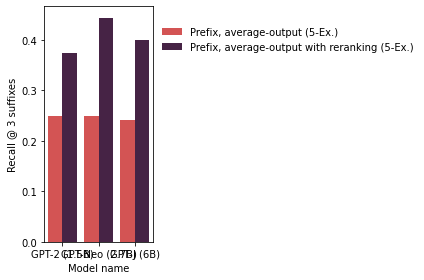

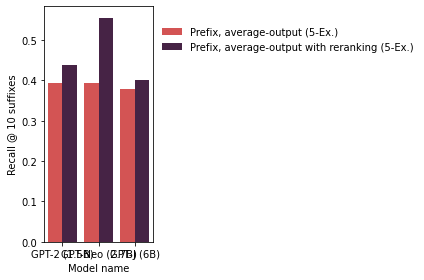

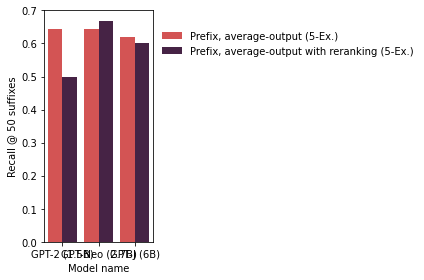

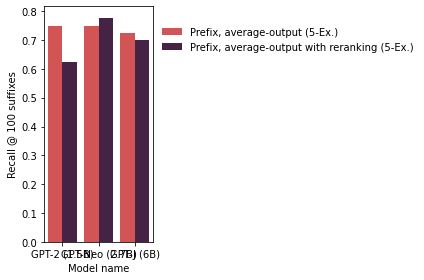

In [39]:
from typing import Dict

# rt = r[r.task_name.isin(['add_two', 'multiply_two', 'subtract_two'])]
import matplotlib.pyplot as plt
rt = r

def make_legend__prefix(table_row: Dict) -> str:
    single_query_str = {
        0: 'average',
        1: 'single'
    }[table_row['single_query']]
    rerank_str = {
        0: '',
        1: ' with reranking'
    }[table_row['do_reranking']]
    
    return 'Prefix, ' + single_query_str + '-output' + rerank_str + f' ({table_row["n_shots"]}-Ex.)'


for metric_key in [#'final_answer_pos_initial_token',
                   f'Recall @ {3} suffixes',
                   f'Recall @ {10} suffixes', 
                   f'Recall @ {50} suffixes', 
                   f'Recall @ {100} suffixes', 
                   ]:
    table = (rt[rt['n_shots'] == 5]
        # mean over templates, task_name)
        .groupby(['checkpoint', 'n_shots', 'do_reranking', 'single_query'])[[metric_key]]
        .mean()
        .reset_index()
    )
    if not len(table): continue
    table['legend'] = table.apply(make_legend__prefix, axis=1)
    analyze_utils.plot_tab(table, metric_key=metric_key, title='ANLI datasets', add_legend=False)

    # if metric_key == 'final_answer_pos_initial_token':
      # plt.savefig('../results/prompt_gen/math_barplot.pdf', bbox_inches='tight')
    plt.show()


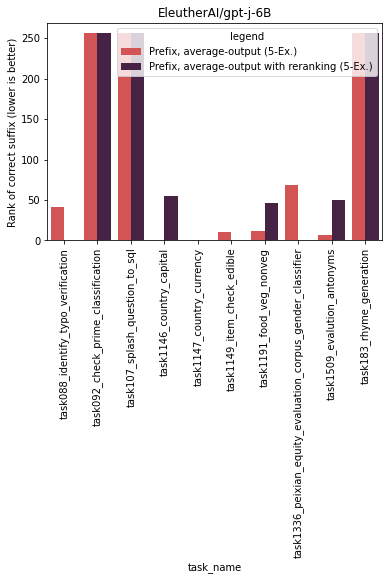

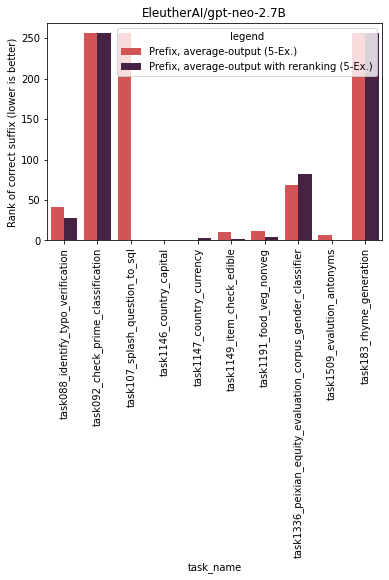

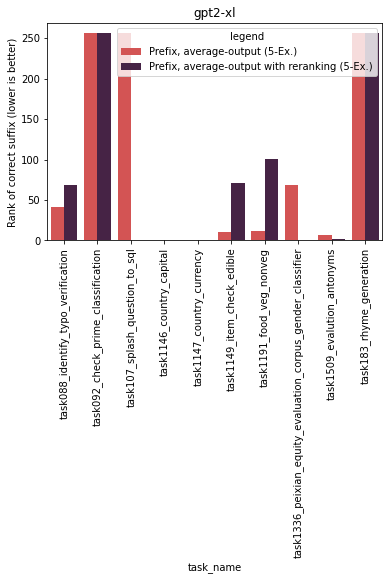

In [40]:
# cols_to_view = r_single_query.columns # cols_to_view
import pandas as pd
import seaborn as sns

key_vars = ['checkpoint', 'n_shots', 'single_query', 'do_reranking', 'task_name']
cols_to_view = [col for col in r.columns if col.startswith('final')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    rg = r.groupby(key_vars)[cols_to_view].mean().round(2)
    # display(rg[rg['final_answer_found'] < 1.0])
    # display(rg)
# r.groupby(['template_num_init_string', 'use_single_query']).median().round(2)['final_model_queries'] # look at templates

for checkpoint in rg.reset_index().checkpoint.unique():
    rp = rg.reset_index().fillna(256)
    # checkpoint = 'EleutherAI/gpt-j-6B'
    metric_key = 'final_answer_pos_initial_token'

    rp = rp[(rp['checkpoint'] == checkpoint) & (rp['n_shots'] == 5)]
    rp['legend'] = rp.apply(make_legend__prefix, axis=1)
    hue_order = analyze_utils.get_hue_order(rp['legend'])
    plt.title(checkpoint)
    sns.barplot(x='task_name', y=metric_key, hue_order=hue_order,
                hue='legend', data=rp, palette=analyze_utils.COLORS)  # data=tab[tab['n_shots'] == 1])
    plt.xticks(rotation='vertical')
    plt.ylabel(analyze_utils.YLABS.get(metric_key, metric_key))
    plt.show()

In [41]:
def get_r_subset(
    checkpoint: str,
    task_name: str, 
    n_shots: int, 
    single_query: bool,
    do_reranking: bool,
) -> pd.DataFrame:
    return r[
        (r['checkpoint'] == checkpoint) &
        (r['task_name'] == task_name) &
        (r['n_shots'] == n_shots) &
        (r['single_query'] == single_query) &
        (r['do_reranking'] == do_reranking)
    ]

t1 = get_r_subset('EleutherAI/gpt-j-6B', 'task092_check_prime_classification', 1, False, True)
print(t1['final_answer_pos_initial_token'].unique())

t2 = get_r_subset('EleutherAI/gpt-j-6B', 'task092_check_prime_classification', 1, True, False)
print(t2['final_answer_pos_initial_token'].unique())

[ 86. 100.]
[]


In [42]:
t1['accs']

0      0.525538
1      0.510923
2      0.501077
3      0.500308
4      0.499538
         ...   
123    0.000000
124    0.000000
125    0.000000
126    0.000000
127    0.000000
Name: accs, Length: 256, dtype: float64

In [43]:
t2.columns

Index(['batch_size', 'max_dset_size', 'seed', 'n_epochs', 'max_digit',
       'template_num_init_string', 'template_num_task_phrasing', 'save_dir',
       'epoch_save_interval', 'lr', 'mlm_num_candidates', 'mlm_name',
       'do_reranking', 'task_name', 'n_shots', 'max_num_samples', 'use_cache',
       'checkpoint', 'llm_float16', 'prefixes', 'prefixes__check_answer_func',
       'json_filename', 'final_answer_full', 'final_answer_pos_initial_token',
       'index', 'losses', 'accs', 'single_query', 'use_single_query',
       'final_model_queries', 'final_answer_added',
       'final_num_suffixes_checked', 'final_answer_depth',
       'final_answer_found', 'Recall @ 3 suffixes', 'Recall @ 5 suffixes',
       'Recall @ 10 suffixes', 'Recall @ 15 suffixes', 'Recall @ 20 suffixes',
       'Recall @ 25 suffixes', 'Recall @ 30 suffixes', 'Recall @ 40 suffixes',
       'Recall @ 50 suffixes', 'Recall @ 75 suffixes', 'Recall @ 100 suffixes',
       'Recall @ 150 suffixes', 'Recall @ 200 suffi

In [44]:
t1[t1['prefixes__check_answer_func']][['prefixes']], t1[t1['prefixes__check_answer_func']][['prefixes', 'accs', 'losses']]

(                                              prefixes
 86   The answer takes the input number and returns ...
 100  The answer takes the input number and returns ...,
                                               prefixes      accs   losses
 86   The answer takes the input number and returns ...  0.007385  0.25929
 100  The answer takes the input number and returns ...  0.000000  2.12192)

In [45]:
t2[t2['prefixes__check_answer_func']][['prefixes']], t2[t2['prefixes__check_answer_func']][['prefixes']].values

(Empty DataFrame
 Columns: [prefixes]
 Index: [],
 array([], shape=(0, 1), dtype=object))